In [1]:
from pymongo import MongoClient
import matplotlib.pyplot as plt
from tqdm import tqdm
import datetime
import pprint
import datetime
import gzip
import json
import sys
import re

%matplotlib inline

### Parser sobre o arquivo de entrada ``amazon-meta.txt.gz`` para gerar um JSON

In [27]:
def get_line_number(file_path):
    sys.stderr.write("Counting line number of {}".format(file_path))
    
    with gzip.open(file_path, 'rb') as file:
        for lines, l in enumerate(file):
            pass
        
    return lines

In [38]:
def parser(filename, total):
    IGNORE_FIELDS = ['Total items', 'reviews']
    f = gzip.open(filename, 'r')
    entry = {}
    categories = []
    reviews = []
    similar_items = []
    
    for line in tqdm(f, total=total):
        line = line.decode("utf-8").strip()
        colonPos = line.find(':')
        
        if line.startswith("Id"):
            if reviews:
                entry["reviews"] = reviews
            if categories:
                entry["categories"] = categories
            
            yield entry
            entry = {}
            categories = []
            reviews = []
            rest = line[colonPos+2:]
            entry["_id"] = int(rest.strip())
        
        elif line.startswith("similar"):
            similar_items = line.split()[2:]
            entry['similar_items'] = similar_items
            
        elif line.find("cutomer:") != -1:
            review_info = line.split()
            reviews.append({'data': review_info[0],'customer_id': review_info[2],'rating': int(review_info[4]),'votes': int(review_info[6]),'helpful': int(review_info[8])})
            
        elif line.startswith("|"):
            categories.append(line)
            
        elif colonPos != -1:
            eName = line[:colonPos]
            rest = line[colonPos+2:]
            
            if not eName in IGNORE_FIELDS:
                entry[eName] = rest.strip()
                if(eName == 'salesrank'):
                    entry[eName] = int(entry[eName])
                
    if reviews:
        entry["reviews"] = reviews
        
    if categories:
        entry["categories"] = categories
        
    yield entry

In [29]:
path_file = 'amazon-meta.txt.gz'

In [30]:
line_num = get_line_number(path_file)

Counting line number of amazon-meta.txt.gz

In [39]:
with open('amazon-meta.json', 'w') as f:
    for e in parser(path_file, total=line_num):
        if e:
            json.dump(e, f)
            f.write('\n')

15010574it [01:57, 127991.28it/s]                              


### Carregar os arquivos no MongoDB

In [491]:
products = []

with open('amazon-meta.json', 'r') as f:
    for line in f:
        products.append(json.loads(line))

In [2]:
client = MongoClient('localhost:27017')

In [3]:
db = client.amazon_meta

In [492]:
# apagar o banco de dados
db.amazon_meta.drop()

In [494]:
db.amazon_meta.insert_many(products)

### Consultas

(a) Dado produto, listar os 5 comentários mais úteis e com maior avaliação e os 5 comentários mais úteis e com menor avaliação

In [4]:
id_product = 2

In [5]:
aggregate = [{
    '$match':{
        '_id': id_product
    }
},{
    '$unwind': '$reviews'
},{
    '$sort':{
        'reviews.helpful': -1,
        'reviews.rating': -1
    }
},{
    '$limit': 5
}]

In [6]:
cursor = db.amazon_meta.aggregate(aggregate)

In [7]:
for doc in cursor:
    print(doc['reviews'])

{'data': '2002-2-6', 'customer_id': 'A2P6KAWXJ16234', 'rating': 4, 'votes': 16, 'helpful': 16}
{'data': '2004-2-11', 'customer_id': 'A1CP26N8RHYVVO', 'rating': 1, 'votes': 13, 'helpful': 9}
{'data': '2002-5-23', 'customer_id': 'A1GIL64QK68WKL', 'rating': 5, 'votes': 8, 'helpful': 8}
{'data': '2002-1-24', 'customer_id': 'A13SG9ACZ9O5IM', 'rating': 5, 'votes': 8, 'helpful': 8}
{'data': '2002-3-23', 'customer_id': 'A3GO7UV9XX14D8', 'rating': 4, 'votes': 6, 'helpful': 6}


(b) Dado um produto, listar os produtos similares com maiores vendas do que ele

In [8]:
id_product = 8

In [9]:
product = db.amazon_meta.find_one({'_id': id_product})

In [10]:
try:
    find = {
        'ASIN': {
            '$in': product['similar_items']
        },
        '$and': [{
            'salesrank':{
                '$lt': product['salesrank']
            }
        }]
    }
except:
    find = {}

In [11]:
cursor = db.amazon_meta.find(find)

In [12]:
for doc in cursor:
    print((doc['_id'], doc['ASIN'], doc['title'], doc['salesrank']))

(10758, 'B000067D0Y', 'The Laramie Project', 3692)
(55461, '080148605X', "We'll Call You If We Need You: Experiences of Women Working Construction", 201253)
(242156, '0300089023', 'Taliban: Militant Islam, Oil and Fundamentalism in Central Asia', 15098)
(453513, '0375727191', 'The Laramie Project (Vintage Originals)', 17854)


(c) Dado um produto, mostrar a evolução diária das médias de avaliação ao longo do intervalo de tempo coberto no arquivo de entrada

In [13]:
id_product = 416378

In [14]:
aggregate = [{
    '$match':{
        '_id': id_product
    }
},{
    '$project':{
        'data': '$reviews.data',
        'rating': '$reviews.rating'
    }
},{
    '$project':{
        '_id': 0,
        'data': 1,
        'rating': 1
    }
}]

In [15]:
cursor = db.amazon_meta.aggregate(aggregate)

In [16]:
try:
    for doc in cursor:
        list_data_rating = [list(i) for i in zip(doc['data'],doc['rating'])]
except:
    list_data_rating = []

In [17]:
date_time_transf = [(list_data_rating[i][0].split('-')[0],list_data_rating[i][0].split('-')[1],list_data_rating[i][0].split('-')[2]) for i in range(len(list_data_rating))]
date_time = sorted([datetime.datetime(int(i[0]),int(i[1]),int(i[2])) for i in date_time_transf])

for i in range(len(list_data_rating)):
    list_data_rating[i][0] = date_time[i]
    
x = [date_time[0] for date_time in list_data_rating]
y = [date_time[1] for date_time in list_data_rating]

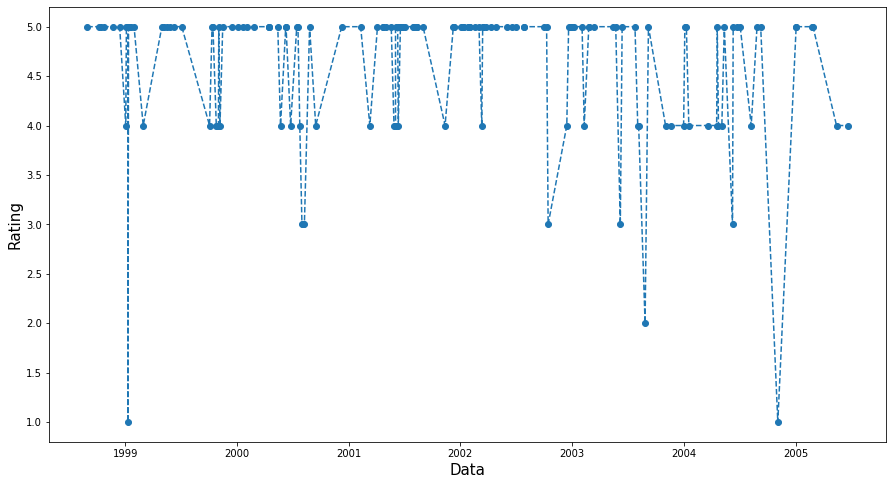

In [18]:
plt.figure(figsize=(15,8))
plt.plot(x,y,'o--')
plt.xlabel('Data',fontsize=15)
plt.ylabel('Rating',fontsize=15)
plt.show()

#caso não tenha plotado nenhum ponto é porque o produto não tem review

(d) Listar os 10 produtos lideres de venda em cada grupo de produtos

In [33]:
aggregate = [{
    '$project':{
        '_id': 1,
        'group': 1,
        'salesrank': 1
    }
},{
    '$sort':{
        'salesrank': 1
    }
},{
    '$group':{
        '_id':{
            'group': '$group',
            'id': '$_id',
            'salesrank': '$salesrank'
        }
    }
},{
    '$group':{
        '_id': '$_id.group',
        'products':{
            '$addToSet':{
                'id': '$_id.id',
                'salesrank': '$_id.salesrank'
            }
        }
    }
},{
    '$project':{
        'group': '$_id',
        'products':{
            '$slice':['$products',10]
        },
        '_id': 0
    }
}]

In [34]:
cursor = db.amazon_meta.aggregate(aggregate, allowDiskUse=True)

OperationFailure: $addToSet used too much memory and cannot spill to disk. Memory limit: 104857600 bytes

In [35]:
for doc in cursor:
    print(doc)

{'group': 'Baby Product', 'mean_helpful': 29.333333333333332}
{'group': 'Sports', 'mean_helpful': 27.2}
{'group': 'Toy', 'mean_helpful': 21.972972972972972}
{'group': 'Software', 'mean_helpful': 17.46153846153846}
{'group': 'Video Games', 'mean_helpful': 15.333333333333334}


(e) Listar os 10 produtos com a maior média de avaliações úteis positivas por produto

In [19]:
aggregate = [{
    '$project':{
        '_id': 1,
        'title': 1,
        'reviews.helpful': 1
    }
},{
    '$unwind': '$reviews'
},{
    '$group':{
        '_id':{
            'id': '$_id',
            'title': '$title'
        },
        'mean_helpful':{
            '$avg': '$reviews.helpful'
        }
    }
},{
    '$project':{
        'id': '$_id.id',
        'title': '$_id.title',
        'mean_helpful': '$mean_helpful',
        '_id': 0
    }
},{
    '$sort':{
        'mean_helpful': -1
    }
},{
    '$limit': 10
}]

In [20]:
cursor = db.amazon_meta.aggregate(aggregate)

In [21]:
for doc in cursor:
    print(doc)

{'id': 380551, 'title': 'Understanding Loved Boys and Boylovers', 'mean_helpful': 243.0}
{'id': 110544, 'title': "T'ai Chi for Older Adults", 'mean_helpful': 233.0}
{'id': 523037, 'title': 'More Than Just Hot Air: Common Sense Counter-Top Convection Oven Cookbook', 'mean_helpful': 203.0}
{'id': 178270, 'title': 'Crockpot Cookery (Cookbooks By Morris Press)', 'mean_helpful': 197.0}
{'id': 250701, 'title': 'Creative Interventions for Troubled Children & Youth', 'mean_helpful': 196.0}
{'id': 312621, 'title': 'The Story About Ping', 'mean_helpful': 186.46511627906978}
{'id': 411581, 'title': 'The Story About Ping (8x 8)', 'mean_helpful': 186.34883720930233}
{'id': 403662, 'title': 'The Story about Ping : StoryTape (StoryTape, Puffin)', 'mean_helpful': 186.32558139534885}
{'id': 357193, 'title': 'The Story about Ping', 'mean_helpful': 186.30232558139534}
{'id': 69111, 'title': 'The Smoked-Foods Cookbook: How to Flavor, Cure, and Prepare Savory Meats, Game, Fish, Nuts, and Cheese', 'mean_hel

(f) Listar a 5 categorias de produto com a maior média de avaliações úteis positivas por produto

In [22]:
aggregate = [{
    '$project':{
        '_id': 1,
        'group': 1,
        'reviews.helpful': 1
    }
},{
    '$unwind': '$reviews'
},{
    '$group':{
        '_id':{
            'group': '$group'
        },
        'mean_helpful':{
            '$avg': '$reviews.helpful'
        }
    }
},{
    '$project':{
        'group': '$_id.group',
        'mean_helpful': '$mean_helpful',
        '_id': 0
    }
},{
    '$sort':{
        'mean_helpful': -1
    }
},{
    '$limit': 5
}]

In [23]:
cursor = db.amazon_meta.aggregate(aggregate)

In [24]:
for doc in cursor:
    print(doc)

{'group': 'Baby Product', 'mean_helpful': 29.333333333333332}
{'group': 'Sports', 'mean_helpful': 27.2}
{'group': 'Toy', 'mean_helpful': 21.972972972972972}
{'group': 'Software', 'mean_helpful': 17.46153846153846}
{'group': 'Video Games', 'mean_helpful': 15.333333333333334}


(g) Listar os 10 clientes que mais fizeram comentários por grupo de produto

In [36]:
aggregate = [{
    '$project':{
        '_id': 1,
        'group': 1,
        'reviews.customer_id': 1
    }
},{
    '$unwind': '$reviews'
},{
    '$group':{
        '_id':{
            'group': '$group',
            'customer_id': '$reviews.customer_id'
        },
        'count':{
            '$sum': 1
        }
    }
},{
    '$project':{
        '_id': 0,
        'group': '$_id.group',
        'customer_id': '$_id.customer_id',
        'count': '$count'
    }
},{
    '$sort':{
        'count': -1
    }
},{
    '$group':{
        '_id': '$group',
        'customers':{
            '$push':{
                'customer_id': '$customer_id',
                'count': '$count'
            }
        }
        
    }
},{
    '$project':{
        'group': '$_id',
        'customers':{
            '$slice':['$customers',10]
        }
    }
}]

In [37]:
cursor = db.amazon_meta.aggregate(aggregate, allowDiskUse=True)

OperationFailure: $push used too much memory and cannot spill to disk. Memory limit: 104857600 bytes

In [38]:
for doc in cursor:
    print(doc)